# 1. Setup

## 1.1 Import Dependencies

In [3]:
import cv2
import os
import uuid
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
import random
from matplotlib import pyplot as plt
import logging

## 1.2 Set GPU Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Configure TensorFlow to handle GPU memory growth and fallback to CPU if necessary
try:
    # Get a list of available GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    else:
        print("No GPU found. Using CPU.")
except RuntimeError as e:
    print(f"Error configuring GPU: {e}")
    print("Fallback to CPU mode.")

# Explicitly set the CPU as a fallback if GPU isn't sufficient or fails
tf.config.set_soft_device_placement(True)


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4715141670818617791
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12758116844229772788
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [5]:
print("Default Device:", tf.config.experimental.get_visible_devices())

Default Device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.3 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Membuat folder jika belum ada
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

print(f"Folder structure created:")
print(f"  Positive Path: {POS_PATH}")
print(f"  Negative Path: {NEG_PATH}")
print(f"  Anchor Path: {ANC_PATH}")

Folder structure created:
  Positive Path: data\positive
  Negative Path: data\negative
  Anchor Path: data\anchor


# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [13]:
# http://vis-www.cs.umass.edu/lfw/

In [14]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz
# code untuk membuka kompresi dan mengekstrak kumpulan data 

In [15]:
# Move LFW Images to the following repository data/negative (memindahkan gambar lfw ke repositori masukkan ke data negative)
#for directory in os.listdir('lfw'):
    #for file in os.listdir(os.path.join('lfw', directory)):
        #EX_PATH = os.path.join('lfw', directory, file)
        #NEW_PATH = os.path.join(NEG_PATH, file)
        #os.replace(EX_PATH, NEW_PATH)

In [13]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

## 2.2 pengambilan gambar

In [7]:
# Establish a connection to the webcam (membuat koneksi ke webcam)
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen (tampilkan gambar kembali layar)
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):   #ketika menekan q maka akan berhenti 
        break
        
# Release the webcam
cap.release()
# Close the image show frame (menurup frame pengambilan gambar)
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
# Fungsi untuk validasi folder
def validate_folder(path, folder_name):
    """
    Validasi apakah folder ada dan tidak kosong.
    Args:
        path (str): Path ke folder.
        folder_name (str): Nama folder untuk error message.
    Raises:
        ValueError: Jika folder tidak ada atau kosong.
    """
    if not os.path.exists(path):
        raise ValueError(f"{folder_name} folder does not exist: {path}")
    if not os.listdir(path):
        raise ValueError(f"{folder_name} folder is empty: {path}")

# Validasi folder anchor, positive, dan negative
validate_folder(ANC_PATH, "Anchor")
validate_folder(POS_PATH, "Positive")
validate_folder(NEG_PATH, "Negative")

# Fungsi untuk memuat dataset gambar
def load_image_paths(path, subfolders=True, shuffle=True):
    """
    Memuat path gambar dari folder dengan opsi subfolder.
    Args:
        path (str): Path ke folder dataset.
        subfolders (bool): Jika True, akan membaca file dari subfolder.
        shuffle (bool): Jika True, path akan diacak.
    Returns:
        tf.data.Dataset: Dataset yang berisi path gambar.
    """
    if subfolders:
        dataset = tf.data.Dataset.list_files(f"{path}/*/*.jpg", shuffle=shuffle)
    else:
        dataset = tf.data.Dataset.list_files(f"{path}/*.jpg", shuffle=shuffle)
    return dataset

# Memuat dataset anchor, positive, dan negative
anchor = load_image_paths(ANC_PATH, subfolders=True)
positive = load_image_paths(POS_PATH, subfolders=True)
negative = load_image_paths(NEG_PATH, subfolders=False)

# Contoh iterasi dataset
print("Loading datasets...")
for batch in anchor.take(1):
    print(f"Anchor example: {batch.numpy().decode('utf-8')}")
for batch in positive.take(1):
    print(f"Positive example: {batch.numpy().decode('utf-8')}")
for batch in negative.take(1):
    print(f"Negative example: {batch.numpy().decode('utf-8')}")

print("Datasets loaded successfully!")

Loading datasets...
Anchor example: data\anchor\adib\aug_1_Adib 3.1.3727ba58-5acf-11ef-8110-3c6aa7c5b821.jpg
Positive example: data\positive\yudith\aug_9_Yudith 2.4ac95463-5aca-11ef-849c-3c6aa7c5b821.jpg
Negative example: data\negative\George_W_Bush_0242.jpg
Datasets loaded successfully!


In [7]:
print(f"Anchor dataset: {len(list(anchor.as_numpy_iterator()))} images loaded.")
print(f"Positive dataset: {len(list(positive.as_numpy_iterator()))} images loaded.")
print(f"Negative dataset: {len(list(negative.as_numpy_iterator()))} images loaded.")

Anchor dataset: 5040 images loaded.
Positive dataset: 21840 images loaded.
Negative dataset: 13233 images loaded.


In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\yudith\\aug_4_Yudith 3.68d2efcb-5ac8-11ef-b3ef-3c6aa7c5b821.jpg'


## 3.2 Preprocessing - Scale and Resize

In [10]:
def preprocess(file_path):
    
    # Read in image from file path (membaca gambar dari file path)
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to be 160x160x3 (mengubah ukuran gambar menjadi 160x160x3)
    img = tf.image.resize(img, (160,160))
    # Scale image to be between 0 and 1 (menskalakan gambar)
    img = img / 255.0
    
    # Return image
    return img

In [11]:
preprocess('data\\anchor\\reza\\aug_0_Reza 3.13d7773f-5ad1-11ef-a0ed-3c6aa7c5b821.jpg')

<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
array([[[0.4697955 , 0.51685435, 0.75214845],
        [0.46495098, 0.5120098 , 0.7473039 ],
        [0.46335784, 0.5104167 , 0.7457108 ],
        ...,
        [0.5660118 , 0.60914904, 0.82875687],
        [0.55112976, 0.594267  , 0.81387484],
        [0.5473039 , 0.59044117, 0.810049  ]],

       [[0.47578508, 0.5228439 , 0.7515204 ],
        [0.47058824, 0.5176471 , 0.7463235 ],
        [0.4689951 , 0.5160539 , 0.7447304 ],
        ...,
        [0.5585746 , 0.60171187, 0.8213197 ],
        [0.5430147 , 0.58615196, 0.8057598 ],
        [0.54632354, 0.5894608 , 0.8090686 ]],

       [[0.49795878, 0.5418313 , 0.77087545],
        [0.48714384, 0.535049  , 0.7587163 ],
        [0.47704887, 0.5257008 , 0.7483724 ],
        ...,
        [0.55474496, 0.5978822 , 0.81749004],
        [0.5461972 , 0.5893344 , 0.80894226],
        [0.5349265 , 0.5780637 , 0.79767156]],

       ...,

       [[0.1645412 , 0.18414906, 0.15669806],
        [0.15

In [12]:
img = preprocess('data\\anchor\\reza\\aug_0_Reza 3.13d7773f-5ad1-11ef-a0ed-3c6aa7c5b821.jpg')

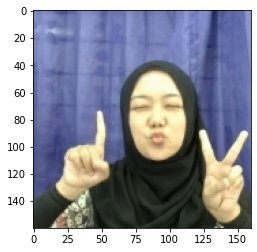

In [13]:
plt.imshow(img)

melihat nilai minimum atau maximum 

In [14]:
img.numpy().min()

0.0018727022

In [15]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

### Penyesuaian positive_pairs dan negative_pairs

In [16]:
def create_anchor_positive_pairs_balanced(anchor_ds, positive_ds, total_pairs_per_individual=2730):
    """
    Membuat pasangan Anchor-Positive dengan total pasangan per individu (setiap anchor memiliki 4-5 pasangan).
    Args:
        anchor_ds (tf.data.Dataset): Dataset Anchor (berisi path gambar anchor).
        positive_ds (tf.data.Dataset): Dataset Positive (berisi path gambar positive).
        total_pairs_per_individual (int): Total pasangan positive per individu.
    Returns:
        List: Daftar pasangan anchor-positive dengan label 1.0.
    """
    # Konversi dataset ke list untuk diakses
    anchor_paths = list(anchor_ds.as_numpy_iterator())
    positive_paths = list(positive_ds.as_numpy_iterator())

    # Buat dictionary untuk positive berdasarkan subfolder individu
    positive_dict = {}
    for pos_path in positive_paths:
        # Ekstrak nama individu dari path
        individual_name = pos_path.decode('utf-8').split(os.sep)[-2]
        if individual_name not in positive_dict:
            positive_dict[individual_name] = []
        positive_dict[individual_name].append(pos_path)

    # Buat dictionary untuk anchor berdasarkan subfolder individu
    anchor_dict = {}
    for anc_path in anchor_paths:
        # Ekstrak nama individu dari path
        individual_name = anc_path.decode('utf-8').split(os.sep)[-2]
        if individual_name not in anchor_dict:
            anchor_dict[individual_name] = []
        anchor_dict[individual_name].append(anc_path)

    # Buat pasangan Anchor-Positive
    positive_pairs = []
    for individual_name in anchor_dict.keys():
        if individual_name in positive_dict:
            anchor_samples = anchor_dict[individual_name]
            positive_samples = positive_dict[individual_name]
            total_anchors = len(anchor_samples)
            base_pairs_per_anchor = total_pairs_per_individual // total_anchors  # Rata-rata pasangan per anchor
            extra_pairs_needed = total_pairs_per_individual % total_anchors  # Sisa pasangan untuk distribusi tambahan

            # Alokasikan pasangan tambahan ke beberapa anchor
            extra_pairs_allocation = [1 if i < extra_pairs_needed else 0 for i in range(total_anchors)]
            random.shuffle(extra_pairs_allocation)  # Acak distribusi pasangan tambahan

            for i, anchor_path in enumerate(anchor_samples):
                # Tentukan jumlah pasangan untuk anchor ini
                num_pairs = base_pairs_per_anchor + extra_pairs_allocation[i]
                selected_samples = random.sample(positive_samples, min(num_pairs, len(positive_samples)))
                positive_pairs.extend([(anchor_path, pos_path, 1.0) for pos_path in selected_samples])

    return positive_pairs


In [17]:
# Buat pasangan Anchor-Positive
positive_pairs = create_anchor_positive_pairs_balanced(anchor, positive, total_pairs_per_individual=2730)

# Print hasil pasangan
print(f"Total Positive Pairs: {len(positive_pairs)}")  # Harus 21840
for pair in positive_pairs[:5]:  # Lihat 5 pasangan pertama
    print(f"Anchor: {pair[0].decode('utf-8')}, Positive: {pair[1].decode('utf-8')}, Label: {pair[2]}")


Total Positive Pairs: 21840
Anchor: data\anchor\meisya\Meisya 3.f136e394-5afe-11ef-ae37-3c6aa7c5b821.jpg, Positive: data\positive\meisya\aug_10_Meisyah.28100edd-5afd-11ef-ada7-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\meisya\Meisya 3.f136e394-5afe-11ef-ae37-3c6aa7c5b821.jpg, Positive: data\positive\meisya\aug_8_Meisyah.6ec0f1cf-5afd-11ef-bfdb-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\meisya\Meisya 3.f136e394-5afe-11ef-ae37-3c6aa7c5b821.jpg, Positive: data\positive\meisya\Meisya 2.2cdb9de6-5afe-11ef-a926-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\meisya\Meisya 3.f136e394-5afe-11ef-ae37-3c6aa7c5b821.jpg, Positive: data\positive\meisya\aug_10_Meisyah.3573ee6a-5afd-11ef-abfa-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\meisya\Meisya 3.2d08e721-5aff-11ef-bc50-3c6aa7c5b821.jpg, Positive: data\positive\meisya\aug_5_Meisyah.309721ae-5afd-11ef-bee5-3c6aa7c5b821.jpg, Label: 1.0


In [18]:
def check_pair_distribution(pairs):
    """
    Memeriksa distribusi jumlah pasangan untuk setiap anchor.
    Args:
        pairs (list): Daftar pasangan berupa (anchor, pair, label).
    Returns:
        dict: Distribusi pasangan per anchor (4_pairs, 5_pairs, out_of_range).
    """
    distribution = {'4_pairs': 0, '5_pairs': 0, 'out_of_range': 0}
    anchor_counts = {}

    # Hitung jumlah pasangan per anchor
    for anchor, _, _ in pairs:
        anchor_decoded = anchor.decode('utf-8')  # Pastikan anchor dalam bentuk string
        if anchor_decoded not in anchor_counts:
            anchor_counts[anchor_decoded] = 0
        anchor_counts[anchor_decoded] += 1

    # Kategorikan jumlah pasangan
    for count in anchor_counts.values():
        if count == 4:
            distribution['4_pairs'] += 1
        elif count == 5:
            distribution['5_pairs'] += 1
        else:
            distribution['out_of_range'] += 1

    return distribution


In [19]:

# Pengecekan distribusi pasangan
positive_distribution = check_pair_distribution(positive_pairs)

print("\nDistribusi Pasangan Positive:")
print(f"Anchor dengan 4 pasangan: {positive_distribution['4_pairs']}")
print(f"Anchor dengan 5 pasangan: {positive_distribution['5_pairs']}")
print(f"Anchor di luar rentang: {positive_distribution['out_of_range']}")


Distribusi Pasangan Positive:
Anchor dengan 4 pasangan: 3360
Anchor dengan 5 pasangan: 1680
Anchor di luar rentang: 0


In [20]:
import random
import tensorflow as tf
import os

def create_anchor_negative_pairs_balanced(anchor_ds, negative_ds, total_pairs_per_individual=2730):
    """
    Membuat pasangan Anchor-Negative dengan total pasangan per individu (setiap anchor memiliki 4 atau 5 pasangan).
    Args:
        anchor_ds (tf.data.Dataset): Dataset Anchor (berisi path gambar anchor).
        negative_ds (tf.data.Dataset): Dataset Negative (berisi path gambar negative).
        total_pairs_per_individual (int): Total pasangan negative per individu.
    Returns:
        List: Daftar pasangan anchor-negative dengan label 0.0.
    """
    # Konversi dataset ke list untuk diakses
    anchor_paths = list(anchor_ds.as_numpy_iterator())
    negative_paths = list(negative_ds.as_numpy_iterator())

    # Buat dictionary untuk anchor berdasarkan subfolder individu
    anchor_dict = {}
    for anc_path in anchor_paths:
        # Ekstrak nama individu dari path
        individual_name = anc_path.decode('utf-8').split(os.sep)[-2]
        if individual_name not in anchor_dict:
            anchor_dict[individual_name] = []
        anchor_dict[individual_name].append(anc_path)

    # Buat pasangan Anchor-Negative
    negative_pairs = []
    for individual_name in anchor_dict.keys():
        anchor_samples = anchor_dict[individual_name]
        total_anchors = len(anchor_samples)
        base_pairs_per_anchor = total_pairs_per_individual // total_anchors  # Rata-rata pasangan per anchor
        extra_pairs_needed = total_pairs_per_individual % total_anchors  # Sisa pasangan untuk distribusi tambahan

        # Alokasikan pasangan tambahan ke beberapa anchor
        extra_pairs_allocation = [1 if i < extra_pairs_needed else 0 for i in range(total_anchors)]
        random.shuffle(extra_pairs_allocation)  # Acak distribusi pasangan tambahan

        for i, anchor_path in enumerate(anchor_samples):
            # Tentukan jumlah pasangan untuk anchor ini
            num_pairs = base_pairs_per_anchor + extra_pairs_allocation[i]
            selected_samples = random.sample(negative_paths, min(num_pairs, len(negative_paths)))
            negative_pairs.extend([(anchor_path, neg_path, 0.0) for neg_path in selected_samples])

    return negative_pairs

# Buat pasangan Anchor-Negative dengan total 2730 pasangan per individu
total_negative_pairs = 2730
negative_pairs = create_anchor_negative_pairs_balanced(anchor, negative, total_negative_pairs)

# Print hasil pasangan
print(f"Total Negative Pairs: {len(negative_pairs)}")  # Harus 21840
for pair in negative_pairs[:5]:  # Lihat 5 pasangan pertama
    print(f"Anchor: {pair[0].decode('utf-8')}, Negative: {pair[1].decode('utf-8')}, Label: {pair[2]}")


Total Negative Pairs: 21840
Anchor: data\anchor\meisya\aug_4_Meisya 3.4301e1ad-5aff-11ef-a023-3c6aa7c5b821.jpg, Negative: data\negative\Gordon_Lightfoot_0001.jpg, Label: 0.0
Anchor: data\anchor\meisya\aug_4_Meisya 3.4301e1ad-5aff-11ef-a023-3c6aa7c5b821.jpg, Negative: data\negative\Hans_Eichel_0003.jpg, Label: 0.0
Anchor: data\anchor\meisya\aug_4_Meisya 3.4301e1ad-5aff-11ef-a023-3c6aa7c5b821.jpg, Negative: data\negative\Hans_Blix_0026.jpg, Label: 0.0
Anchor: data\anchor\meisya\aug_4_Meisya 3.4301e1ad-5aff-11ef-a023-3c6aa7c5b821.jpg, Negative: data\negative\Elizabeth_Smart_0001.jpg, Label: 0.0
Anchor: data\anchor\meisya\aug_4_Meisya 3.4301e1ad-5aff-11ef-a023-3c6aa7c5b821.jpg, Negative: data\negative\Antony_Leung_0002.jpg, Label: 0.0


In [21]:
negative_distribution = check_pair_distribution(negative_pairs)

print("\nDistribusi Pasangan Negative:")
print(f"Anchor dengan 4 pasangan: {negative_distribution['4_pairs']}")
print(f"Anchor dengan 5 pasangan: {negative_distribution['5_pairs']}")
print(f"Anchor di luar rentang: {negative_distribution['out_of_range']}")



Distribusi Pasangan Negative:
Anchor dengan 4 pasangan: 3360
Anchor dengan 5 pasangan: 1680
Anchor di luar rentang: 0


In [22]:
# Buat pasangan Anchor-Positive
positive_pairs = create_anchor_positive_pairs_balanced(anchor, positive, total_pairs_per_individual=2730)

# Print hasil pasangan
print(f"Total Positive Pairs: {len(positive_pairs)}")
for pair in positive_pairs[:5]:
    print(f"Anchor: {pair[0].decode('utf-8')}, Positive: {pair[1].decode('utf-8')}, Label: {pair[2]}")


Total Positive Pairs: 21840
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Positive: data\positive\dwi\aug_7_DWI 2.87e18faf-5ac0-11ef-9ba3-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Positive: data\positive\dwi\aug_1_dwi.b492f52b-5a19-11ef-b77a-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Positive: data\positive\dwi\DWI 2.e6dadae3-5ac0-11ef-91f5-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Positive: data\positive\dwi\aug_11_dwi.0e9b7119-5a1a-11ef-9d43-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Positive: data\positive\dwi\aug_0_dwi.b970d50f-5a19-11ef-8d40-3c6aa7c5b821.jpg, Label: 1.0


In [23]:
# Periksa distribusi pasangan
positive_distribution = check_pair_distribution(positive_pairs)

# Print distribusi pasangan
print("\nDistribusi Pasangan Positive:")
print(f"Anchor dengan 4 pasangan: {positive_distribution['4_pairs']}")
print(f"Anchor dengan 5 pasangan: {positive_distribution['5_pairs']}")
print(f"Anchor di luar rentang: {positive_distribution['out_of_range']}")



Distribusi Pasangan Positive:
Anchor dengan 4 pasangan: 3360
Anchor dengan 5 pasangan: 1680
Anchor di luar rentang: 0


In [24]:
# Periksa distribusi pasangan
negative_distribution = check_pair_distribution(negative_pairs)

# Print distribusi pasangan
print("\nDistribusi Pasangan Negative:")
print(f"Anchor dengan 4 pasangan: {negative_distribution['4_pairs']}")
print(f"Anchor dengan 5 pasangan: {negative_distribution['5_pairs']}")
print(f"Anchor di luar rentang: {negative_distribution['out_of_range']}")


Distribusi Pasangan Negative:
Anchor dengan 4 pasangan: 3360
Anchor dengan 5 pasangan: 1680
Anchor di luar rentang: 0


In [25]:
# ✅ Fungsi untuk mengubah pasangan ke tf.data.Dataset
def pairs_to_dataset(pairs):
    """
    Mengonversi daftar pasangan ke tf.data.Dataset.
    Args:
        pairs (list): Daftar pasangan berupa (anchor, pair, label).
    Returns:
        tf.data.Dataset: Dataset berupa ((anchor, pair), label).
    """
    anchors = [pair[0] for pair in pairs]
    pairs_paths = [pair[1] for pair in pairs]
    labels = [pair[2] for pair in pairs]  # ✅ List langsung ke tf.float32

    anchors_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(anchors, dtype=tf.string))
    pairs_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(pairs_paths, dtype=tf.string))
    labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))

    return tf.data.Dataset.zip(((anchors_ds, pairs_ds), labels_ds))

# ✅ Buat dataset dari pasangan positif dan negatif
positive_ds = pairs_to_dataset(positive_pairs)
negative_ds = pairs_to_dataset(negative_pairs)

# ✅ Gabungkan dataset positif dan negatif
data = positive_ds.concatenate(negative_ds).prefetch(tf.data.AUTOTUNE)  # 🔹 Hapus shuffle di sini!


# Debug dataset
print("Dataset Element Spec:", data.element_spec)
for example in data.take(5):
    print(f"Anchor: {example[0][0].numpy().decode('utf-8')}, Pair: {example[0][1].numpy().decode('utf-8')}, Label: {example[1].numpy()}")


Dataset Element Spec: ((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(), dtype=tf.float32, name=None))
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Pair: data\positive\dwi\aug_7_DWI 2.87e18faf-5ac0-11ef-9ba3-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Pair: data\positive\dwi\aug_1_dwi.b492f52b-5a19-11ef-b77a-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Pair: data\positive\dwi\DWI 2.e6dadae3-5ac0-11ef-91f5-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Pair: data\positive\dwi\aug_11_dwi.0e9b7119-5a1a-11ef-9d43-3c6aa7c5b821.jpg, Label: 1.0
Anchor: data\anchor\dwi\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg, Pair: data\positive\dwi\aug_0_dwi.b970d50f-5a19-11ef-8d40-3c6aa7c5b821.jpg, Label: 1.0


In [26]:
len(positive_ds)

21840

In [27]:
len(negative_ds)

21840

In [28]:
len(data)

43680

In [29]:
samples = data.as_numpy_iterator()

In [30]:
example = samples.next()

In [31]:
example

((b'data\\anchor\\dwi\\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg',
  b'data\\positive\\dwi\\aug_7_DWI 2.87e18faf-5ac0-11ef-9ba3-3c6aa7c5b821.jpg'),
 1.0)

## 3.4 Build Train and Test Partition

In [32]:
# Fungsi untuk preprocess pasangan anchor, pair, dan label
def preprocess_twin(input_img, validation_img, label):
    """
    Preprocess pasangan gambar (anchor dan pair) dan label.
    Args:
        input_img (str): Path gambar anchor.
        validation_img (str): Path gambar pair (positif/negatif).
        label (float): Label pasangan (1.0 untuk positif, 0.0 untuk negatif).
    Returns:
        tuple: Pasangan gambar yang diproses dan label.
    """
    return preprocess(input_img), preprocess(validation_img), label

In [33]:
# Ambil satu contoh dari dataset
samples = data.as_numpy_iterator()
example = samples.next()

# Debug contoh dataset
print("Example Debug:", example)

Example Debug: ((b'data\\anchor\\dwi\\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg', b'data\\positive\\dwi\\aug_7_DWI 2.87e18faf-5ac0-11ef-9ba3-3c6aa7c5b821.jpg'), 1.0)


Example Debug: ((b'data\\anchor\\dwi\\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg', b'data\\positive\\dwi\\aug_1_dwi.b492f52b-5a19-11ef-b77a-3c6aa7c5b821.jpg'), 1.0)


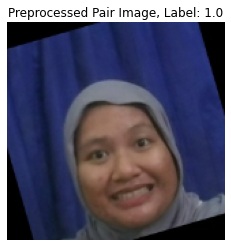

In [34]:
# Debug contoh dataset untuk melihat struktur elemen
example = samples.next()
print("Example Debug:", example)

# Pecah elemen dataset sesuai struktur
input_img = example[0][0]          # Path gambar anchor
validation_img = example[0][1]     # Path gambar pair (positive/negative)
label = example[1]                 # Label (1.0 atau 0.0)

# Panggil fungsi preprocess_twin dengan argumen yang benar
res = preprocess_twin(input_img, validation_img, label)

# Visualisasi hasil preprocessing
plt.imshow(res[1].numpy())  # Gambar pair (validation_img)
plt.title(f"Preprocessed Pair Image, Label: {res[2]}")
plt.axis("off")
plt.show()


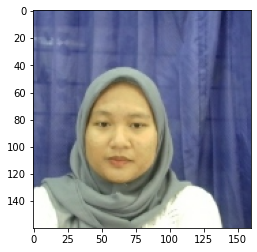

In [35]:
plt.imshow(res[0])

In [36]:
res[2]

1.0

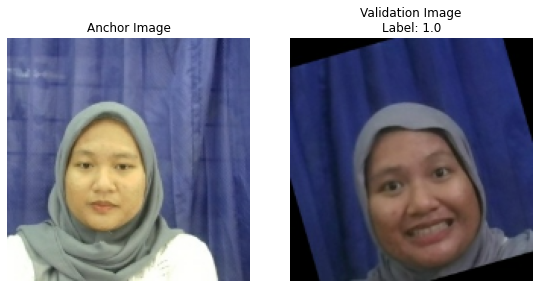

In [37]:
# Plot kedua gambar (Anchor dan Validation)
plt.figure(figsize=(8, 4))

# Gambar Anchor
plt.subplot(1, 2, 1)
plt.imshow(res[0].numpy())  # Gambar anchor
plt.title("Anchor Image")
plt.axis("off")

# Gambar Validation (Positive/Negative)
plt.subplot(1, 2, 2)
plt.imshow(res[1].numpy())  # Gambar pair (validation_img)
plt.title(f"Validation Image\nLabel: {res[2]}")
plt.axis("off")

# Tampilkan kedua gambar
plt.tight_layout()
plt.show()


### Build Data Loader Pipeline

In [38]:
for element in data.take(1):
    print("Dataset Element:", element)


Dataset Element: ((<tf.Tensor: shape=(), dtype=string, numpy=b'data\\anchor\\dwi\\aug_0_DWI 3.65626491-5ac6-11ef-9207-3c6aa7c5b821.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\positive\\dwi\\aug_7_DWI 2.87e18faf-5ac0-11ef-9ba3-3c6aa7c5b821.jpg'>), <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)


In [39]:
import tensorflow as tf

# ✅ **Tetapkan Global Seed agar hasil tetap konsisten**
SEED = 81
tf.random.set_seed(SEED)
random.seed(SEED)  # Seed untuk operasi Python
np.random.seed(SEED)  # Seed untuk NumPy

# ✅ **Preprocessing Pipeline dengan Seed**
data = data.map(lambda x, y: preprocess_twin(x[0], x[1], y), num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()  # ✅ Cache setelah preprocessing
# ✅ **Gunakan Seed saat Shuffling agar urutan tetap sama**
data = data.shuffle(buffer_size=43680, seed=SEED).prefetch(tf.data.AUTOTUNE)


In [40]:
for example in data.take(1):
    print(f"Anchor Image Shape: {example[0][0].shape}")
    print(f"Pair Image Shape: {example[0][1].shape}")
    print(f"Label: {example[1]}")


Anchor Image Shape: (160, 3)
Pair Image Shape: (160, 3)
Label: [[[0.42352942 0.2627451  0.09019608]
  [0.42352942 0.2627451  0.09019608]
  [0.42352942 0.2627451  0.09019608]
  ...
  [0.38488817 0.21850874 0.07132353]
  [0.36519608 0.19656862 0.06080729]
  [0.34785923 0.17923178 0.05153569]]

 [[0.42352942 0.2627451  0.08357843]
  [0.42352942 0.2627451  0.08357843]
  [0.42352942 0.2627451  0.08357843]
  ...
  [0.45331648 0.28333718 0.12647825]
  [0.45168504 0.27974877 0.13700597]
  [0.45465687 0.2827206  0.14607844]]

 [[0.42034313 0.26433823 0.08235294]
  [0.42034313 0.26433823 0.08235294]
  [0.42034313 0.26433823 0.08235294]
  ...
  [0.46847042 0.28881356 0.1210095 ]
  [0.47057673 0.29030713 0.13417585]
  [0.46817937 0.28460094 0.13705193]]

 ...

 [[0.09857154 0.09857154 0.20053232]
  [0.11053538 0.11715303 0.215805  ]
  [0.1143727  0.12221584 0.22025506]
  ...
  [0.20067784 0.19675627 0.22623698]
  [0.1892425  0.18532093 0.2135072 ]
  [0.13227251 0.12835094 0.15653722]]

 [[0.094826

In [41]:
data

<PrefetchDataset shapes: ((160, 160, 3), (160, 160, 3), ()), types: (tf.float32, tf.float32, tf.float32)>

In [42]:
samples = data.as_numpy_iterator()

In [43]:
len(samples.next())

3

In [44]:
samp = samples.next()

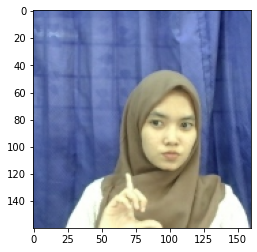

In [45]:
plt.imshow(samp[0])

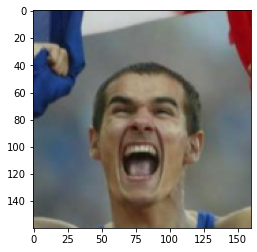

In [46]:
plt.imshow(samp[1])

In [47]:
samp[2]

0.0

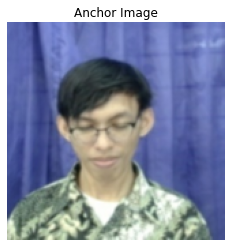

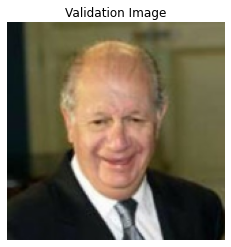

Label: 0.0


In [48]:
# Mendapatkan iterator dari data untuk mengakses elemen
samples = data.as_numpy_iterator()

# Mengambil sampel pertama dari iterator
example = samples.next()

# Visualisasi gambar Anchor
plt.imshow(example[0])  # Menampilkan gambar anchor
plt.title("Anchor Image")
plt.axis('off')  # Menghilangkan sumbu untuk tampilan yang lebih bersih
plt.show()

# Visualisasi gambar Validation
plt.imshow(example[1])  # Menampilkan gambar validation
plt.title("Validation Image")
plt.axis('off')  # Menghilangkan sumbu untuk tampilan yang lebih bersih
plt.show()

# Menampilkan label
print("Label:", example[2])  # Menampilkan label (1 untuk pasangan positif, 0 untuk negatif)

### Training dan testing partition

In [49]:
# ✅ **Hitung total data dengan aman**
data_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.7 * data_size)  # 70% untuk training
test_size = data_size - train_size  # 30% untuk testing

In [50]:
# ✅ **Split train-test secara konsisten**
train_data = data.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)  # ✅ Batch + Prefetch langsung
test_data = data.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
round(len(data) * 0.7)

30576

In [52]:
round(len(data) * 0.3)

13104

In [53]:
len(test_data)

410

In [54]:
len(train_data)

956

In [55]:
train_samples = train_data.as_numpy_iterator()

In [56]:
train_samples

In [57]:
train_sample = train_samples.next()

In [58]:
train_sample

(array([[[[3.43692541e-01, 4.06437665e-01, 6.41731799e-01],
          [3.50122541e-01, 4.12867635e-01, 6.48161769e-01],
          [3.35619628e-01, 3.98364723e-01, 6.32065713e-01],
          ...,
          [4.11071539e-01, 4.73816633e-01, 7.09110737e-01],
          [3.75022978e-01, 4.36542600e-01, 6.72449470e-01],
          [3.65196079e-01, 4.20098037e-01, 6.59313738e-01]],
 
         [[3.50172341e-01, 4.12917435e-01, 6.48211539e-01],
          [3.56249988e-01, 4.18995112e-01, 6.54289186e-01],
          [3.40927541e-01, 4.03672636e-01, 6.37373626e-01],
          ...,
          [4.01834399e-01, 4.64579493e-01, 6.99873626e-01],
          [3.79262418e-01, 4.40782011e-01, 6.76688850e-01],
          [3.61887246e-01, 4.16789204e-01, 6.56004906e-01]],
 
         [[3.55924487e-01, 4.23448980e-01, 6.57149971e-01],
          [3.49636197e-01, 4.17160690e-01, 6.50861681e-01],
          [3.34417135e-01, 4.00000006e-01, 6.32755041e-01],
          ...,
          [4.00980383e-01, 4.62132365e-01, 6.9583

In [59]:
len(train_sample)

3

In [60]:
len(train_sample[0])

32

## Build Embedding Layer

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Matikan GPU sebelum TensorFlow diimpor

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # Harus kosong


[]


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14574649317632145452
]


In [3]:
import tensorflow as tf

# Periksa perangkat yang terlihat oleh TensorFlow
print("Available devices:")
for device in tf.config.experimental.get_visible_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Matikan GPU
import tensorflow as tf

# Periksa apakah hanya CPU yang tersedia
print(tf.config.list_physical_devices('GPU'))  # Ini harus kosong


[]


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17359641162731853022
]


In [7]:
import tensorflow as tf

# Nonaktifkan semua GPU secara manual
tf.config.set_visible_devices([], 'GPU')

# Verifikasi bahwa GPU tidak lagi terdeteksi
print(tf.config.list_physical_devices('GPU'))  # Output harus kosong


[]


In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

# Verifikasi bahwa GPU tidak terdeteksi
print(tf.config.list_physical_devices('GPU'))  # Harus kosong


[]


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14465801101159754025
xla_global_id: -1
]


In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

def make_mobilenetv2_embedding():
    """
    Model embedding menggunakan MobileNetV2 sebagai feature extractor.
    """
    inp = Input(shape=(160, 160, 3), name='input_image')

    # ✅ MobileNetV2 tanpa pretrained weights agar lebih fleksibel
    base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights=None)

    x = base_model(inp)
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = BatchNormalization()(x)  # ✅ Batch Normalization untuk stabilitas

    # ✅ Dense Layer dengan regulasi agar lebih stabil
    x = Dense(4096, activation='relu', kernel_regularizer=l2(0.005), name='dense1')(x)
    x = Dropout(0.5)(x)  # ✅ Dropout untuk mengurangi overfitting

    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.005), name='dense2')(x)
    x = Dropout(0.5)(x)

    # ✅ Embedding dengan ukuran 512 untuk representasi fitur
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.005), name='dense3')(x)

    # ✅ L2 Normalization pada embedding agar jarak lebih stabil
    normalized_output = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l2_norm')(x)

    return Model(inputs=[inp], outputs=[normalized_output], name='MobileNetV2_Embedding')

# ✅ Buat model embedding
mobilenetv2_embedding = make_mobilenetv2_embedding()
mobilenetv2_embedding.summary()

Model: "MobileNetV2_Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense1 (Dense)               (None, 4096)              5246976   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense2 (Dense)               (None, 1024)    

## Build Distance Layer

In [62]:
# ✅ Distance Layer dengan L1 Distance
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Make Siamese Model

In [63]:
def make_siamese_model(): 
    """Membuat model Siamese dengan L1 Distance dan tanpa sigmoid untuk Contrastive Loss."""
    
    # Input untuk gambar anchor dan validation
    input_image = Input(name='input_img', shape=(160,160,3))
    validation_image = Input(name='validation_img', shape=(160,160,3))
    
    # Dapatkan embedding dari model embedding
    embedding_anchor = mobilenetv2_embedding(input_image)
    embedding_validation = mobilenetv2_embedding(validation_image)
    
    # Hitung jarak Euclidean antara embedding
    distance = Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], axis=1), name="euclidean_distance")([embedding_anchor, embedding_validation])

    return Model(inputs=[input_image, validation_image], outputs=distance, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
MobileNetV2_Embedding (Function (None, 512)          12230208    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
euclidean_distance (Lambda)     (None,)              0           MobileNetV2_Embeddin

# Training cnn + siamese 

## 5.1 Setup Loss and Optimizer

In [64]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.backend import epsilon  # ✅ Hindari error numerik

def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    Contrastive loss untuk model Siamese, memastikan nilai stabil.
    """
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1e6)  # ✅ Pastikan tetap dalam range aman
    squared_pred = tf.square(y_pred)  # ✅ Jarak yang dikuadratkan
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))  # ✅ Hindari negatif

    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)


In [65]:
# ✅ Optimizer dengan Cyclical Learning Rate
opt = tf.keras.optimizers.Adam(
    learning_rate=ExponentialDecay(
        initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.95  # ✅ Sedikit lebih smooth
    )
)

In [66]:
# ✅ ReduceLROnPlateau dengan patience lebih pendek untuk deteksi cepat
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-6
)

In [67]:
# ✅ Augmentasi menggunakan fungsi manual untuk TensorFlow 2.6.2
def random_brightness(image, seed=None):
    return tf.image.stateless_random_brightness(image, max_delta=0.1, seed=seed)  # ✅ Gunakan seed opsional

def random_contrast(image, seed=None):
    return tf.image.stateless_random_contrast(image, lower=0.9, upper=1.1, seed=seed)  # ✅ Seed untuk stabilitas

def augment_validation(image, label, seed=None):
    seed = seed or tf.random.uniform([2], maxval=10000, dtype=tf.int32)  # ✅ Pastikan seed tersedia
    image = random_brightness(image, seed)
    image = random_contrast(image, seed)
    return image, label

## 5.2 Establish Checkpoints

In [68]:
import os
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Buat direktori jika belum ada
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [69]:
test_batch = train_data.as_numpy_iterator()

In [70]:
batch_1 = test_batch.next()

In [71]:
X = batch_1[:2]

In [72]:
y = batch_1[2]

In [73]:
y

array([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [74]:
@tf.function
def train_step(batch):
    """
    Training step untuk model Siamese dengan Contrastive Loss.
    """
    with tf.GradientTape() as tape:
        X = batch[:2]  # Input (anchor, positive/negative)
        y = batch[2]   # Label

        yhat = siamese_model(X, training=True)  # Forward pass
        loss = contrastive_loss(y, yhat)  # Hitung Contrastive Loss

        # ✅ Pastikan loss berupa skalar
        loss = tf.reduce_mean(loss)

    # ✅ Gunakan tf.print() agar tidak error di @tf.function
    tf.print("Train Loss:", loss)

    # ✅ Cek apakah loss bernilai NaN atau Inf
    loss_invalid = tf.math.is_nan(loss) | tf.math.is_inf(loss)
    
    # ✅ Jika loss tidak valid, skip update parameter
    if loss_invalid:
        tf.print("⚠️ Warning: Loss is NaN or Inf, skipping gradient update!")
        return loss  # ✅ Skip step jika loss tidak valid

    # Hitung Gradien
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # ✅ Cek apakah ada gradient None
    valid_gradients = [g for g in grad if g is not None]
    if len(valid_gradients) == 0:
        tf.print("⚠️ All gradients are None! Skipping parameter update!")
        return loss  # ✅ Skip step jika semua gradien None

    # ✅ Jika ada beberapa gradien None, tetap lakukan update
    if any(g is None for g in grad):
        tf.print("⚠️ Some gradients are None! Updating only valid gradients.")

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # ✅ Logging learning rate
    lr = opt._decayed_lr(tf.float32)
    tf.print("Current Learning Rate:", lr)

    return loss


## 5.4 Build Training Loop

In [75]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [76]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, min_epochs=5):
        """
        Early Stopping untuk menghentikan training jika tidak ada perbaikan dalam jumlah epoch tertentu.

        Args:
            patience (int): Jumlah epoch tanpa peningkatan sebelum berhenti.
            min_delta (float): Perbedaan minimal antara loss terbaik dan loss baru agar dihitung sebagai peningkatan.
            min_epochs (int): Minimum jumlah epoch sebelum early stopping bisa aktif.
        """
        self.patience = max(1, patience)  # ✅ Pastikan patience tidak nol
        self.min_delta = max(0, min_delta)  # ✅ Pastikan min_delta tidak negatif
        self.best_loss = np.inf  # ✅ Gunakan np.inf untuk keakuratan numerik
        self.wait = 0
        self.stop_training = False
        self.epoch_count = 0  # ✅ Lacak jumlah epoch

        self.min_epochs = max(1, min_epochs)  # ✅ Tetapkan batas minimum epoch sebelum early stop bekerja
    
    def on_epoch_end(self, current_loss):
        """
        Evaluasi Early Stopping setelah setiap epoch.

        Args:
            current_loss (float): Loss validasi dari epoch saat ini.
        """
        self.epoch_count += 1  # ✅ Hitung jumlah epoch

        # ✅ Jangan aktifkan Early Stopping sebelum minimum epoch tercapai
        if self.epoch_count < self.min_epochs:
            print(f"🔹 Early Stopping disabled: Waiting for {self.min_epochs - self.epoch_count} more epochs...")
            return

        # ✅ Cek apakah current_loss valid
        if np.isnan(current_loss) or np.isinf(current_loss):
            print(f"⚠️ Warning: Invalid loss detected (NaN/Inf) → Ignored for Early Stopping.")
            return

        # ✅ Jika terjadi peningkatan signifikan dalam loss, reset patience
        if (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            remaining_epochs = self.patience - self.wait
            print(f"🔸 Early Stopping Check: {remaining_epochs} epoch(s) left before stopping...")

            if self.wait >= self.patience:
                self.stop_training = True
                print(f"🚨 Early Stopping Triggered! Best Loss: {self.best_loss:.4f}, Current Loss: {current_loss:.4f}")


In [77]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, Recall, Precision
from tensorflow.keras.backend import epsilon  # ✅ Untuk menghindari error F1-Score

# ✅ Fungsi Evaluasi dengan Threshold untuk Contrastive Loss
def evaluate_test_data(test_data, threshold=0.5):
    mse = MeanSquaredError()
    mae = MeanAbsoluteError()
    recall_metric = Recall()
    precision_metric = Precision()
    val_loss_list = []  # ✅ Simpan loss di list untuk rata-rata nanti
    correct_predictions = tf.Variable(0.0, dtype=tf.float32)  # ✅ Gunakan TensorFlow Variable untuk akumulasi
    total_samples = tf.Variable(0.0, dtype=tf.float32)

    for test_input_batch, test_val_batch, y_true_batch in test_data.as_numpy_iterator():
        yhat_batch = siamese_model.predict([test_input_batch, test_val_batch])

        # ✅ Simpan nilai loss sebagai Tensor (pastikan loss dalam list tidak menyebabkan error)
        val_loss_list.append(tf.convert_to_tensor(contrastive_loss(y_true_batch, yhat_batch)))

        # ✅ Update MSE dan MAE
        mse.update_state(y_true_batch, yhat_batch)
        mae.update_state(y_true_batch, yhat_batch)

        # ✅ Konversi output model ke nilai biner berdasarkan threshold
        y_pred_binary = tf.cast(yhat_batch < threshold, dtype=tf.float32)  # Jika jarak < threshold → dianggap sama (1)

        # ✅ Update Recall dan Precision
        recall_metric.update_state(y_true_batch, y_pred_binary)
        precision_metric.update_state(y_true_batch, y_pred_binary)

        # ✅ Hitung akurasi manual langsung dalam TensorFlow
        correct_predictions.assign_add(tf.reduce_sum(tf.cast(y_pred_binary == y_true_batch, dtype=tf.float32)))
        total_samples.assign_add(tf.cast(tf.size(y_true_batch), dtype=tf.float32))  # ✅ Pastikan total_samples tetap Tensor

    # ✅ Hitung Rata-Rata Metrik (gunakan tf.numpy() hanya di akhir)
    val_loss = tf.reduce_mean(tf.stack(val_loss_list)).numpy()  # ✅ Konversi ke numpy setelah perhitungan selesai
    val_mse = mse.result().numpy()
    val_mae = mae.result().numpy()
    val_recall = recall_metric.result().numpy()
    val_precision = precision_metric.result().numpy()
    val_accuracy = (correct_predictions / (total_samples + epsilon())).numpy()  # ✅ Hindari pembagian oleh nol
    val_f1_score = (2 * val_precision * val_recall) / (val_precision + val_recall + epsilon())  # ✅ Stabilitas numerik

    return val_loss, val_mse, val_mae, val_recall, val_precision, val_accuracy, val_f1_score  # ✅ Mengembalikan 7 metrik evaluasi


In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(history, save_path='training_metrics.png'):
    if not history or len(history.get('loss', [])) == 0:
        print("⚠️ History kosong! Tidak ada data untuk diplot.")
        return
    
    epochs = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # ✅ Tambahkan lebih banyak subplot untuk metrik tambahan
    fig.suptitle("Training Metrics Over Epochs", fontsize=16)  # ✅ Tambahkan judul utama

    # ✅ Accuracy Based on Threshold
    if 'threshold_accuracy' in history and len(history['threshold_accuracy']) > 0:
        axes[0, 0].plot(epochs, history['threshold_accuracy'], label='Training Accuracy (Threshold)', marker='o')
        axes[0, 0].plot(epochs, history.get('val_threshold_accuracy', []), label='Validation Accuracy (Threshold)', linestyle='--', marker='s')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Accuracy Based on Threshold')
        axes[0, 0].grid(True, linestyle='--', alpha=0.6)
        axes[0, 0].legend()
        axes[0, 0].set_ylim(0, 1.1)  # ✅ Batasan skala lebih jelas

    # ✅ Loss Plot
    if 'loss' in history and len(history['loss']) > 0:
        axes[0, 1].plot(epochs, history['loss'], label='Training Loss', marker='o')
        axes[0, 1].plot(epochs, history.get('val_loss', []), label='Validation Loss', linestyle='--', marker='s')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Training and Validation Loss')
        axes[0, 1].grid(True, linestyle='--', alpha=0.6)
        axes[0, 1].legend()

    # ✅ Learning Rate Plot
    if 'learning_rate' in history and len(history['learning_rate']) > 0:
        axes[0, 2].plot(epochs, history['learning_rate'], label='Learning Rate', color='purple', marker='o')
        axes[0, 2].set_xlabel('Epochs')
        axes[0, 2].set_ylabel('Learning Rate')
        axes[0, 2].set_title('Learning Rate Schedule')
        axes[0, 2].grid(True, linestyle='--', alpha=0.6)
        axes[0, 2].legend()

    # ✅ MSE Plot
    if 'mse' in history and len(history['mse']) > 0:
        axes[1, 0].plot(epochs, history['mse'], label='Training MSE', marker='o')
        axes[1, 0].plot(epochs, history.get('val_mse', []), label='Validation MSE', linestyle='--', marker='s')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('MSE')
        axes[1, 0].set_title('Mean Squared Error')
        axes[1, 0].grid(True, linestyle='--', alpha=0.6)
        axes[1, 0].legend()

    # ✅ MAE Plot
    if 'mae' in history and len(history['mae']) > 0:
        axes[1, 1].plot(epochs, history['mae'], label='Training MAE', marker='o')
        axes[1, 1].plot(epochs, history.get('val_mae', []), label='Validation MAE', linestyle='--', marker='s')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('MAE')
        axes[1, 1].set_title('Mean Absolute Error')
        axes[1, 1].grid(True, linestyle='--', alpha=0.6)
        axes[1, 1].legend()

    # ✅ F1 Score Plot
    if 'f1_score' in history and len(history['f1_score']) > 0:
        axes[1, 2].plot(epochs, history['f1_score'], label='Training F1 Score', marker='o')
        axes[1, 2].plot(epochs, history.get('val_f1_score', []), label='Validation F1 Score', linestyle='--', marker='s')
        axes[1, 2].set_xlabel('Epochs')
        axes[1, 2].set_ylabel('F1 Score')
        axes[1, 2].set_title('F1 Score Over Epochs')
        axes[1, 2].grid(True, linestyle='--', alpha=0.6)
        axes[1, 2].legend()
        axes[1, 2].set_ylim(0, 1.1)  # ✅ Jaga agar skala tetap 0-1

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    # ✅ Additional plot for Precision and Recall
    if 'precision' in history and 'recall' in history and len(history['precision']) > 0 and len(history['recall']) > 0:
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, history['precision'], label='Training Precision', marker='o')
        plt.plot(epochs, history.get('val_precision', []), label='Validation Precision', linestyle='--', marker='s')
        plt.plot(epochs, history['recall'], label='Training Recall', marker='o')
        plt.plot(epochs, history.get('val_recall', []), label='Validation Recall', linestyle='--', marker='s')

        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Precision & Recall Over Epochs')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        plt.tight_layout()
        plt.savefig('precision_recall.png')
        plt.show()


In [79]:
# ✅ Fungsi Training yang Disesuaikan untuk Contrastive Loss
def train(data, test_data, EPOCHS, min_epoch=5):
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    
    # ✅ Pastikan semua metrik disimpan
    history = {
        'loss': [], 'mse': [], 'mae': [], 'recall': [], 'precision': [], 'threshold_accuracy': [], 'f1_score': [],
        'val_loss': [], 'val_mse': [], 'val_mae': [], 'val_recall': [], 'val_precision': [], 'val_threshold_accuracy': [], 'val_f1_score': [],
        'learning_rate': []
    }

    for epoch in range(1, EPOCHS + 1):
        print(f"\n🔹 Epoch {epoch}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(data))

        # ✅ Inisialisasi metrik training
        mse = MeanSquaredError()
        mae = MeanAbsoluteError()
        recall_metric = Recall()
        precision_metric = Precision()
        correct_predictions = tf.Variable(0.0, dtype=tf.float32)  # ✅ Gunakan TensorFlow Variable untuk akumulasi
        total_samples = tf.Variable(0.0, dtype=tf.float32)
        epoch_loss_list = []  # ✅ Simpan loss tiap batch untuk stabilitas

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            loss_value = tf.reduce_mean(loss).numpy()  # ✅ Pastikan scalar yang valid
            epoch_loss_list.append(loss_value)  # ✅ Simpan loss tiap batch

            # ✅ Periksa apakah loss menjadi NaN atau Inf
            if np.isnan(loss_value) or np.isinf(loss_value):
                print("⚠️ Training dihentikan karena loss tidak valid (NaN atau Inf).")
                return history  # ✅ Stop training dan kembalikan hasil sejauh ini

            # ✅ Prediksi dan evaluasi batch
            yhat = siamese_model.predict(batch[:2])
            mse.update_state(batch[2], yhat)
            mae.update_state(batch[2], yhat)

            # ✅ Konversi ke biner untuk Recall & Precision
            y_pred_binary = tf.cast(yhat < 0.5, dtype=tf.float32)  # Anggap threshold = 0.5
            y_true_binary = tf.cast(batch[2], dtype=tf.float32)  # ✅ Pastikan dtype sama
            
            recall_metric.update_state(y_true_binary, y_pred_binary)
            precision_metric.update_state(y_true_binary, y_pred_binary)

            # ✅ Hitung Threshold-Based Accuracy
            correct_predictions.assign_add(tf.reduce_sum(tf.cast(y_pred_binary == y_true_binary, dtype=tf.float32)))
            total_samples.assign_add(tf.cast(tf.size(y_true_binary), dtype=tf.float32))

            progbar.update(idx + 1)

        epoch_loss = np.mean(epoch_loss_list)  # ✅ Hitung rata-rata loss epoch
        mse_score = mse.result().numpy()
        mae_score = mae.result().numpy()
        recall_score = recall_metric.result().numpy()
        precision_score = precision_metric.result().numpy()
        threshold_accuracy = (correct_predictions / (total_samples + tf.keras.backend.epsilon())).numpy()
        f1_score = (2 * precision_score * recall_score) / (precision_score + recall_score + tf.keras.backend.epsilon())  # ✅ Hindari NaN

        # ✅ Simpan metrik ke history
        history['loss'].append(epoch_loss)
        history['mse'].append(mse_score)
        history['mae'].append(mae_score)
        history['recall'].append(recall_score)
        history['precision'].append(precision_score)
        history['threshold_accuracy'].append(threshold_accuracy)
        history['f1_score'].append(f1_score)

        # ✅ Simpan Learning Rate
        current_lr = opt._decayed_lr(tf.float32).numpy()
        history['learning_rate'].append(current_lr)

        print(f"✅ Train → Loss: {epoch_loss:.4f}, MSE: {mse_score:.4f}, MAE: {mae_score:.4f}, Recall: {recall_score:.4f}, Precision: {precision_score:.4f}, Accuracy: {threshold_accuracy:.4f}, F1-Score: {f1_score:.4f}, LR: {current_lr:.8f}")

        # ✅ Evaluasi pada test_data
        val_loss, val_mse, val_mae, val_recall, val_precision, val_threshold_accuracy, val_f1_score = evaluate_test_data(test_data)

        # ✅ Simpan metrik validasi ke history
        history['val_loss'].append(val_loss)
        history['val_mse'].append(val_mse)
        history['val_mae'].append(val_mae)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)
        history['val_threshold_accuracy'].append(val_threshold_accuracy)
        history['val_f1_score'].append(val_f1_score)

        print(f"🔹 Val → Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, Accuracy: {val_threshold_accuracy:.4f}, F1-Score: {val_f1_score:.4f}, LR: {current_lr:.8f}")

        # ✅ **Cek Early Stopping dengan minimal 5 epoch**
        if epoch >= min_epoch:
            early_stopping.on_epoch_end(val_loss)
            if early_stopping.stop_training:
                print(f"🚨 Early stopping triggered at epoch {epoch}! Best Loss: {early_stopping.best_loss:.4f}")
                break
        else:
            print(f"🔸 Early stopping disabled for first {min_epoch} epochs. Continuing training...")

        # ✅ Simpan model setiap 10 epoch
        if epoch % 1 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # ✅ Tampilkan grafik setelah training selesai
    plot_metrics(history)

    return history


In [80]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, Recall, Precision

## 5.5 Train the model

In [81]:
EPOCHS = 20

# Start training



🔹 Epoch 1/20
Train Loss: 0.640307069
Current Learning Rate: 9.99994882e-05
  1/956 [..............................] - ETA: 6:11:53Train Loss: 0.571358323
Current Learning Rate: 9.99989716e-05
  2/956 [..............................] - ETA: 59:26  Train Loss: 0.341961056
Current Learning Rate: 9.99984622e-05
  3/956 [..............................] - ETA: 59:02Train Loss: 0.491210669
Current Learning Rate: 9.99979457e-05
  4/956 [..............................] - ETA: 1:01:09Train Loss: 0.525287032
Current Learning Rate: 9.99974363e-05
  5/956 [..............................] - ETA: 1:02:00Train Loss: 0.407083809
Current Learning Rate: 9.99969197e-05
  6/956 [..............................] - ETA: 1:01:21Train Loss: 0.404659688
Current Learning Rate: 9.99964104e-05
  7/956 [..............................] - ETA: 1:00:04Train Loss: 0.364195734
Current Learning Rate: 9.99958938e-05
  8/956 [..............................] - ETA: 59:19  Train Loss: 0.405026615
Current Learning Rate: 9.999

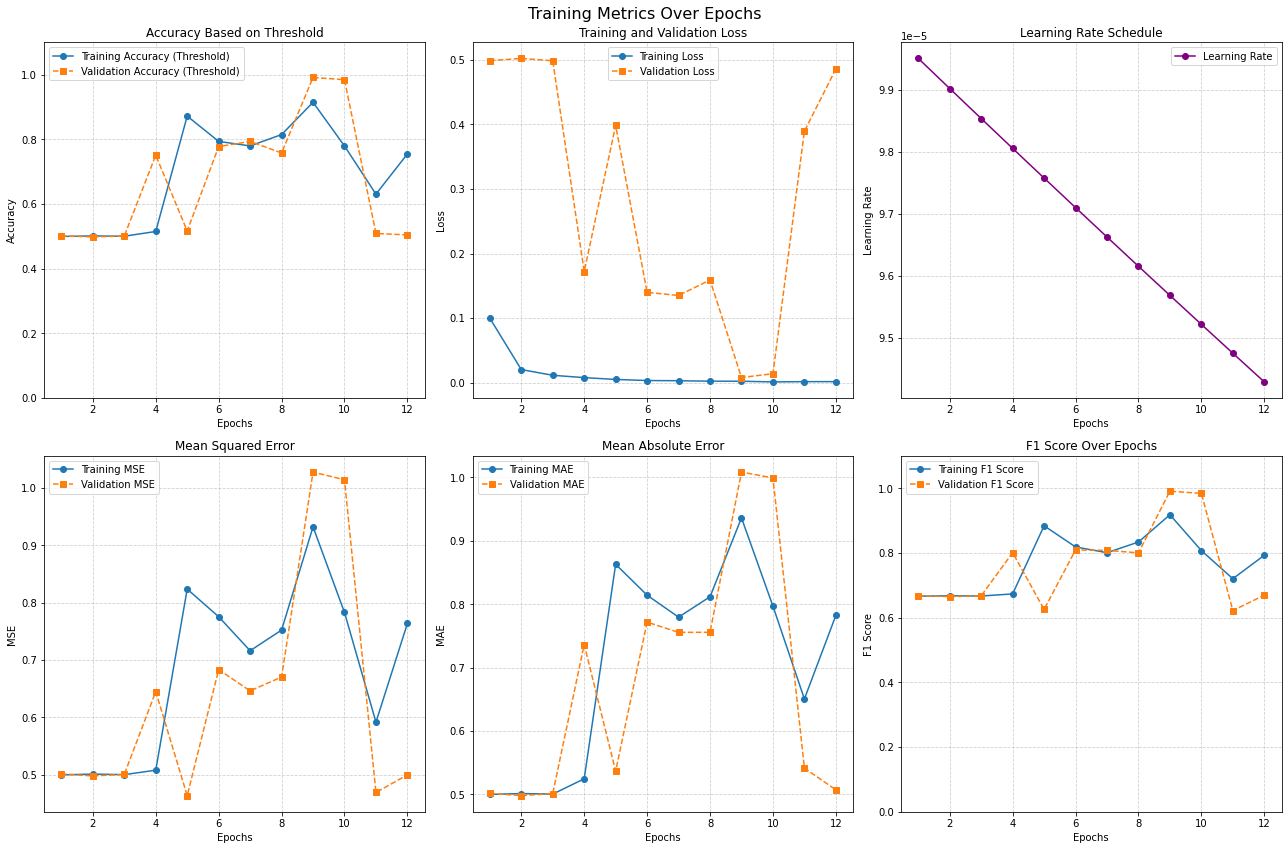

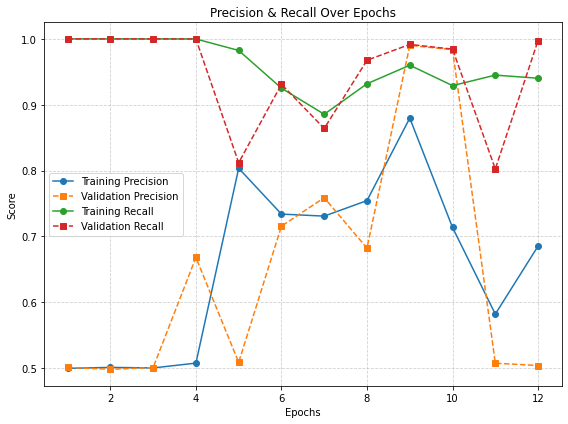

In [82]:
# Jalankan training dan simpan history
history = train(train_data, test_data, EPOCHS)


In [83]:
import json
import numpy as np

class NumpyFloatEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.float32, tf.float32)):  # Jika menemukan float32 dari numpy atau tensorflow
            return float(obj)  # Ubah ke float standar Python
        return super().default(obj)

# Simpan history ke JSON dengan encoder kustom
with open('history.json', 'w') as f:
    json.dump(history, f, indent=4, cls=NumpyFloatEncoder)  # ✅ Konversi otomatis float32 → float


##### Load history.json

In [84]:
import json
import pandas as pd
from IPython.display import display  # ✅ Gunakan display() untuk Jupyter Notebook

# ✅ Muat data history dari JSON
with open('history.json', 'r') as f:
    history = json.load(f)

# ✅ Buat DataFrame dari history.json
epochs = list(range(1, len(history['loss']) + 1))  # Ambil jumlah epoch dari history
df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': history['loss'],
    'Val Loss': history['val_loss'],
    'Train MSE': history['mse'],
    'Val MSE': history['val_mse'],
    'Train MAE': history['mae'],
    'Val MAE': history['val_mae'],
    'Train Recall': history['recall'],
    'Val Recall': history['val_recall'],
    'Train Precision': history['precision'],
    'Val Precision': history['val_precision'],
    'Train Accuracy': history['threshold_accuracy'],
    'Val Accuracy': history['val_threshold_accuracy'],
    'Train F1-Score': history['f1_score'],
    'Val F1-Score': history['val_f1_score']
})

# ✅ Tampilkan DataFrame dalam notebook
display(df)  # ✅ Gunakan display() agar tabel muncul rapi di Jupyter Notebook


,Epoch,Train Loss,Val Loss,Train MSE,Val MSE,Train MAE,Val MAE,Train Recall,Val Recall,Train Precision,Val Precision,Train Accuracy,Val Accuracy,Train F1-Score,Val F1-Score
0,1,0.100010,0.498524,0.499819,0.501475,0.499819,0.501475,1.000000,1.000000,0.499689,0.501106,0.499689,0.501106,0.666390,0.667649
1,2,0.020389,0.502080,0.501179,0.497913,0.501179,0.497915,1.000000,1.000000,0.501161,0.498283,0.501161,0.498283,0.667698,0.665139
2,3,0.011565,0.498329,0.500201,0.500697,0.500315,0.501184,1.000000,1.000000,0.500311,0.500877,0.500311,0.500877,0.666943,0.667446
3,4,0.007926,0.172177,0.507939,0.645002,0.524438,0.736412,0.999935,1.000000,0.507637,0.668122,0.514996,0.750630,0.673406,0.801047
4,5,0.005138,0.398185,0.823832,0.463594,0.863021,0.536532,0.982473,0.811877,0.803554,0.508652,0.871594,0.516444,0.884052,0.625451
5,6,0.003435,0.139921,0.775658,0.683459,0.814255,0.771758,0.925219,0.931107,0.733972,0.715690,0.793361,0.777413,0.818573,0.809309
6,7,0.003127,0.135083,0.716315,0.646285,0.779586,0.755601,0.885565,0.864008,0.730889,0.758855,0.779428,0.793361,0.800827,0.808025
7,8,0.002416,0.159047,0.752384,0.670475,0.811743,0.755709,0.931893,0.967619,0.754467,0.682281,0.814522,0.757573,0.833846,0.800277
8,9,0.002349,0.008117,0.932410,1.027949,0.936266,1.008548,0.960068,0.991649,0.879761,0.990117,0.914211,0.990996,0.918162,0.990882
9,10,0.001283,0.013993,0.783040,1.014530,0.796961,0.999340,0.929074,0.984503,0.713658,0.983756,0.779231,0.984052,0.807242,0.984129


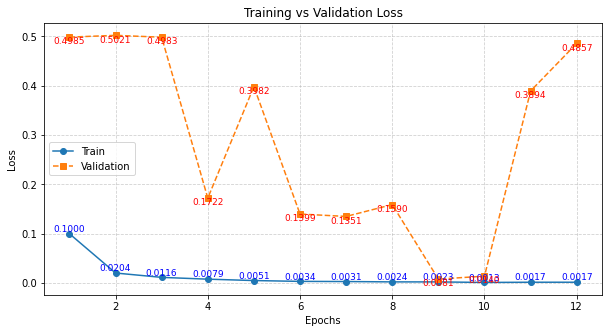

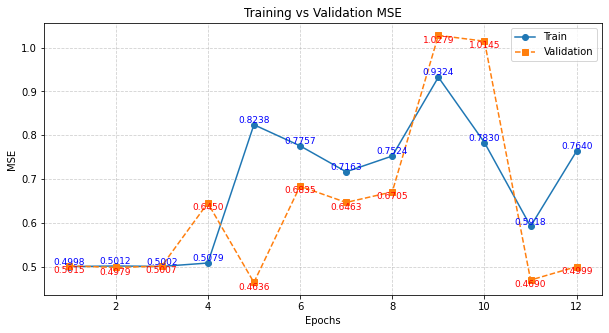

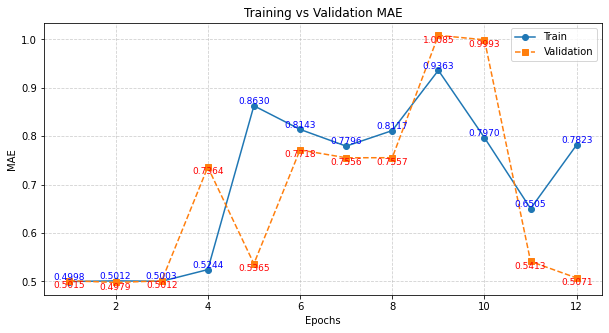

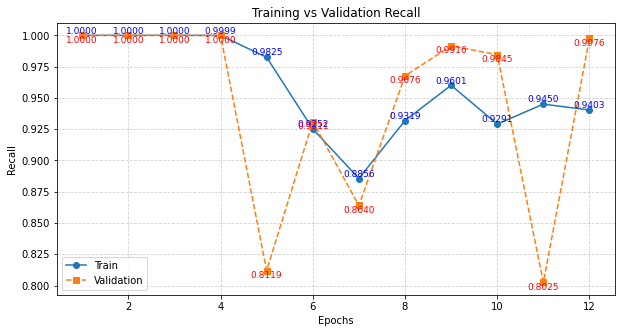

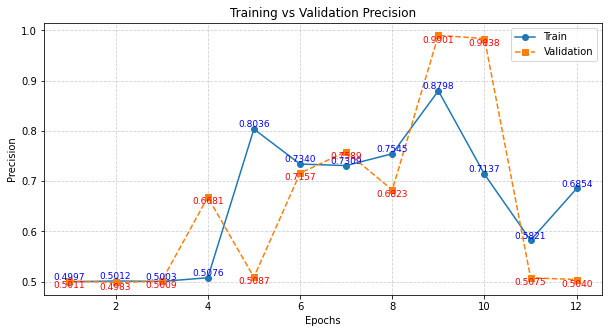

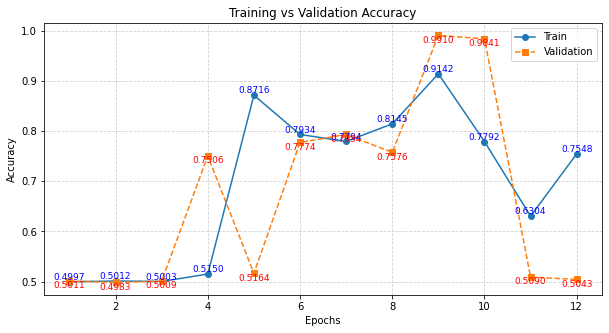

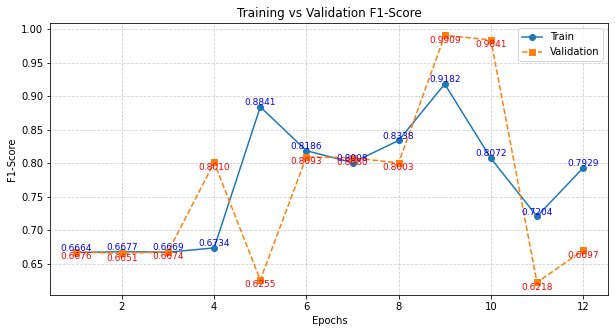

In [85]:
# ✅ Fungsi untuk membuat plot dengan anotasi nilai di atas titik
def plot_with_values(x, y_train, y_val, ylabel, title):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y_train, marker='o', linestyle='-', label='Train')
    plt.plot(x, y_val, marker='s', linestyle='--', label='Validation')

    # Tambahkan nilai di atas titik-titik pada grafik
    for i in range(len(x)):
        plt.text(x[i], y_train[i], f"{y_train[i]:.4f}", ha='center', va='bottom', fontsize=9, color='blue')
        plt.text(x[i], y_val[i], f"{y_val[i]:.4f}", ha='center', va='top', fontsize=9, color='red')

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# ✅ Buat semua plot dengan nilai
plot_with_values(df['Epoch'], df['Train Loss'], df['Val Loss'], "Loss", "Training vs Validation Loss")
plot_with_values(df['Epoch'], df['Train MSE'], df['Val MSE'], "MSE", "Training vs Validation MSE")
plot_with_values(df['Epoch'], df['Train MAE'], df['Val MAE'], "MAE", "Training vs Validation MAE")
plot_with_values(df['Epoch'], df['Train Recall'], df['Val Recall'], "Recall", "Training vs Validation Recall")
plot_with_values(df['Epoch'], df['Train Precision'], df['Val Precision'], "Precision", "Training vs Validation Precision")
plot_with_values(df['Epoch'], df['Train Accuracy'], df['Val Accuracy'], "Accuracy", "Training vs Validation Accuracy")
plot_with_values(df['Epoch'], df['Train F1-Score'], df['Val F1-Score'], "F1-Score", "Training vs Validation F1-Score")

## 6.4 Viz Results

NameError: name 'test_input' is not defined

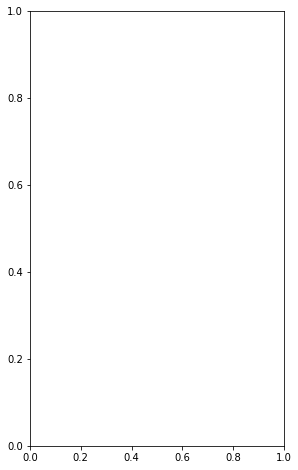

In [128]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [86]:
# Save weights
siamese_model.save('siamesemodel_mobilenetv2.h5')

c:\Users\IBN_Y\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
siamese_model.save('siamesemodel')  # SavedModel format

In [199]:
L1Dist

__main__.L1Dist

In [117]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel_L1NormalizationCNN.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

OSError: SavedModel file does not exist at: siamesemodel_L1NormalizationCNN.h5\{saved_model.pbtxt|saved_model.pb}

In [85]:
# Recompile the model
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [100]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.9892096 ],
       [0.01824746],
       [0.9893848 ],
       [0.01344678],
       [0.02132842],
       [0.01497614],
       [0.9922481 ],
       [0.9870281 ],
       [0.01687151],
       [0.0098961 ],
       [0.01163024],
       [0.01052761],
       [0.9891139 ],
       [0.9911654 ],
       [0.9885653 ],
       [0.01697287]], dtype=float32)

In [201]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         178421056   input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test